In [20]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [7]:
data = pd.read_csv('pima_indians_diabetes.csv')
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Data Dictionary

* Pregnancies: Number of pregnancies
* Glucose: Plasma glucose concentration
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age in years
* Outcome: Class variable (0 or 1, indicating diabetes status)
  

In [10]:
# Separate features and target variable
features = data.drop(columns=['Outcome'])
target = data['Outcome']

In [12]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [36]:
# Perform PCA
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a dataframe for PCA results
pca_results = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio
})

# Save PCA results for visualization
pca_results_path = 'pca_results.csv'
pca_results.to_csv(pca_results_path, index=False)

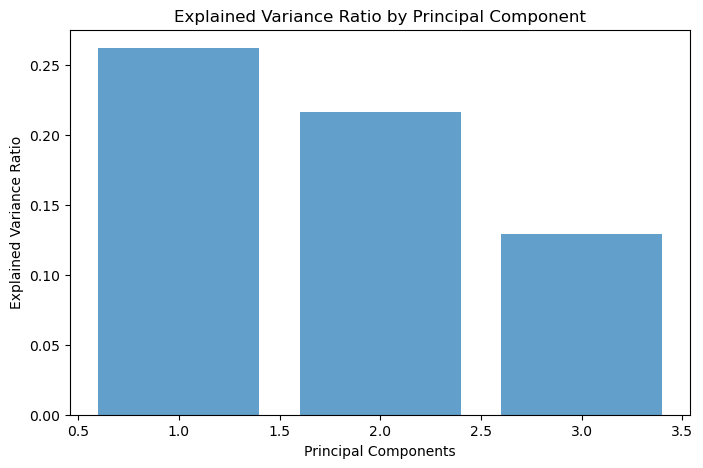

In [38]:
# Prepare the explained variance plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()


In [40]:
# Save the PCA-transformed dataset
pca_features_path = 'pca_transformed_features.csv'
pca_features_df = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
pca_features_df['Outcome'] = target.values
pca_features_df.to_csv(pca_features_path, index=False)

### Training RandomForest Model Using PCA Components

* **PCA Components**: We use the top 5 principal components as features for the model.
* **Train-Test Split**: The dataset is split into training (70%) and testing (30%) sets, ensuring stratification for balanced class proportions.
* **Random Forest Model**:
    * random_state=42: Ensures reproducibility.
    * n_estimators=100: Uses 100 trees in the forest.
* **Model Validation**:
    * The accuracy_score computes the overall accuracy.
    * The classification_report provides precision, recall, and F1-score for each class.

In [42]:

# Use the first few principal components for training (decide based on explained variance)
num_components = 3  # Choose top 3 components (can adjust as needed)
X_pca = features_pca[:, :num_components]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.3, random_state=42, stratify=target)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)


Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       150
           1       0.60      0.46      0.52        81

    accuracy                           0.70       231
   macro avg       0.67      0.65      0.65       231
weighted avg       0.69      0.70      0.69       231



**Note**: The classification report indicates that the model performs better for classifying class 0 than class 1.

### Identify Feature Importances


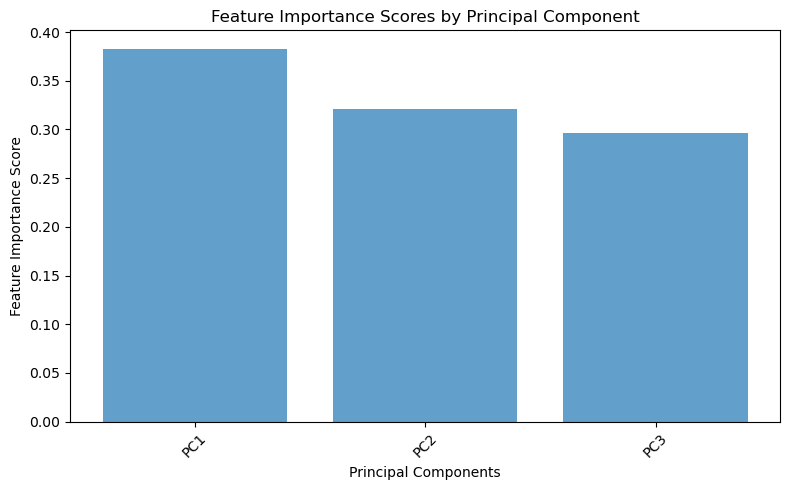

In [54]:
# Get feature importances from the Random Forest model
feature_importances = rf_model.feature_importances_

# Create labels for the principal components used
labels = [f'PC{i+1}' for i in range(num_components)]

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.bar(labels, feature_importances, alpha=0.7)
plt.xlabel('Principal Components')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance Scores by Principal Component')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### Making Predictions with New Data

To make predictions with new data using the Random Forest model trained on PCA-transformed features, you need to preprocess the data as follows:

1. Standardize the new data: Ensure the new data is scaled using the same _StandardScaler_ used on the training data.
2. Transform using PCA: Project the standardized data onto the principal components using the trained PCA object.
3. Make Predictions: Use the trained Random Forest model to make predictions on the transformed data.

In [44]:
# Example new data 
new_data = [[5, 120, 70, 25, 100, 30.0, 0.5, 35]]  # Replace with new data rows

# Step 1: Standardize the new data
new_data_scaled = scaler.transform(new_data)  # Use the previously trained scaler

# Step 2: Transform using PCA
new_data_pca = pca.transform(new_data_scaled)[:, :num_components]  # Project onto top components

# Step 3: Make predictions
new_predictions = rf_model.predict(new_data_pca)

print("Predicted Outcome:", new_predictions)


Predicted Outcome: [0]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Mapping New Data to Principal Components

Principal components are linear combinations of the original standardized features. Each principal component is defined by its loadings, which are the weights assigned to each feature during PCA.

**Steps:**

1. The original standardized feature vector (e.g., [z1, z2, ..., zn]) is multiplied by the loading matrix of PCA.
2. The output is a lower-dimensional representation where each principal component captures a combination of the original features.

For example, if PCA assigns weights to features as:

* PC1 = 0.3*Glucose + 0.4*BloodPressure + ...
* PC2 = -0.2*Glucose + 0.5*BMI + ...

The transformation involves multiplying these weights by the respective scaled feature values in the new data.